In [97]:
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve
import numpy as np
import plotly.express as px
import shap
import seaborn as sns
from IPython import display
import matplotlib.pyplot as plt
import awswrangler as wr
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    multilabel_confusion_matrix,
)
from catboost.utils import select_threshold
from skmultilearn.model_selection.iterative_stratification import (
    IterativeStratification,
)
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm import tqdm
from catboost.utils import get_roc_curve, select_threshold
from torchmetrics.classification import BinaryPrecisionRecallCurve
from supervised.automl import AutoML
import warnings
from loguru import logger

warnings.filterwarnings("ignore")


In [98]:
wr.config.s3_endpoint_url = "http://192.168.1.4:8333"

multilabelDf = wr.s3.read_parquet(
    path=f"s3://multilabel_df/",
    dataset=True,
)
multilabelDf.columns

Index(['vision_bonnet', 'vision_bumper_front', 'vision_grille',
       'vision_headlamp_rh', 'vision_headlamp_lh', 'vision_door_front_lh',
       'vision_door_front_rh', 'vision_engine', 'vision_bumper_rear',
       'vision_misc', 'vision_front_panel', 'vision_non_external',
       'vision_wheel', 'vision_fender_front_lh', 'vision_fender_front_rh',
       'vision_rear_quarter_lh', 'vision_tail_lamp_lh', 'vision_tail_lamp_rh',
       'vision_windscreen_front', 'vision_rear_compartment',
       'vision_rear_panel', 'vision_rear_quarter_rh', 'vision_door_rear_rh',
       'vision_door_rear_lh', 'bonnet', 'bumper_front', 'grille',
       'fog_lamp_rh', 'headlamp_lh', 'headlamp_rh', 'door_front_lh',
       'door_front_rh', 'air_conditioning', 'cooling_fan', 'radiator',
       'bumper_rear', 'misc', 'engine', 'airbag', 'front_panel',
       'undercarriage', 'wheel', 'fender_front_lh', 'fender_front_rh',
       'door_mirror_rh', 'rear_quarter_lh', 'interior', 'tail_lamp_lh',
       'fog_lamp_l

In [99]:
allVisionFeatures = [x for x in multilabelDf.columns if "vision_" in x]
caseFeatures = [
    "Circumstances_of_Accident",
     "Model",
        "Vehicle_Still_Driveable",
        "NCB_Stat",
        "Assembly_Type",
        "Claim_Type",
        "Vehicle_Type",
        "Sum_Insured",
        "Repairer",
        "Repairer_Apprv_Count",
        "Collision_With",
        "Handling_Insurer",
]
allInputFeature = caseFeatures + allVisionFeatures
targetCol = [
    x for x in multilabelDf.columns if x not in allInputFeature and x != "CaseID"
]
multilabelDf[caseFeatures]

,Circumstances_of_Accident,Model,Vehicle_Still_Driveable,NCB_Stat,Assembly_Type,Claim_Type,Vehicle_Type,Sum_Insured,Repairer,Repairer_Apprv_Count,Collision_With,Handling_Insurer
0,Collision- Head to Rear (Insured Hit TP),HR-V 2015 On,0,1,3,OD,SUV - 5 Dr,63000.0,Million Car Auto Specialist Sdn Bhd (HQ),1163,Private Vehicle,AXA Affin General Insurance Berhad
1,Lost control- Overturned,Saga 2019 On,0,1,3,OD,Saloon - 4 Dr,39000.0,Top Diversified Sdn Bhd (Top Diversified),1058,Private Vehicle,Allianz General Insurance Company (Malaysia) B...
2,,Wira 1993 On,0,1,3,OD,Hatchback - 5 Dr,8000.0,The Apple Auto Services & Tyres Sdn Bhd (The A...,6031,Private Vehicle,Etiqa General Insurance Berhad
3,Collided into animal,Hilux 1999 On,0,1,3,OD,Pickup - 4 Dr Dbl.Cab,16000.0,Bengkel Baru Seng Soon Sdn Bhd (HQ),1686,Others,MSIG INSURANCE (MALAYSIA) BHD
4,Collision- Head to Rear (Insured Hit TP),Civic 2006 On,0,1,3,OD,Saloon - 4 Dr,44000.0,LB Performance Auto Works Sdn Bhd (HQ),600,Private Vehicle,Zurich General Insurance Malaysia Berhad
...,...,...,...,...,...,...,...,...,...,...,...,...
598121,,Almera 2015 On,1,0,3,OD EXW,Saloon - 4 Dr,40000.0,Tan Chong Ekspres Auto Servis Sdn Bhd (PJ),0,,RHB Insurance Berhad
598122,Collision- Head to Rear (TP Hit Insured),City 2014 On,1,0,3,OD KFK,Saloon - 4 Dr,48000.0,New Way Motor Workshop Sdn Bhd (HQ),3234,Private Vehicle,Tokio Marine Insurans (Malaysia) Berhad
598123,,Almera 2015 On,1,0,3,OD EXW,Saloon - 4 Dr,40000.0,Tan Chong Ekspres Auto Servis Sdn Bhd (Kuantan...,0,,RHB Insurance Berhad
598124,,Almera 2015 On,1,0,2,OD EXW,Saloon - 4 Dr,40000.0,Tan Chong Ekspres Auto Servis Sdn Bhd (K.Teren...,0,,RHB Insurance Berhad


In [100]:
# multilabelDf.replace("NaT",np.NaN, inplace=True)

In [101]:
# multilabelDf[multilabelDf["Vehicle_Still_Driveable"] == "NaT"]

In [102]:
# multilabelDf.fillna(0,inplace=True)


In [103]:
targetCol

['bonnet',
 'bumper_front',
 'grille',
 'fog_lamp_rh',
 'headlamp_lh',
 'headlamp_rh',
 'door_front_lh',
 'door_front_rh',
 'air_conditioning',
 'cooling_fan',
 'radiator',
 'bumper_rear',
 'misc',
 'engine',
 'airbag',
 'front_panel',
 'undercarriage',
 'wheel',
 'fender_front_lh',
 'fender_front_rh',
 'door_mirror_rh',
 'rear_quarter_lh',
 'interior',
 'tail_lamp_lh',
 'fog_lamp_lh',
 'tail_lamp_rh',
 'windscreen_front',
 'rear_compartment',
 'rear_panel',
 'rear_quarter_rh',
 'door_rear_rh',
 'door_mirror_lh',
 'door_rear_lh',
 'windscreen_rear']

In [104]:
wr.config.s3_endpoint_url = "http://192.168.1.4:8333"

multilabelDf = wr.s3.read_parquet(
        path=f"s3://multilabel_df/",
        dataset=True,
    )
allVisionFeatures = [x for x in multilabelDf.columns if "vision_" in x]
caseFeatures = [
    "Circumstances_of_Accident",
    "Model",
    "Vehicle_Still_Driveable",
    "NCB_Stat",
    "Assembly_Type",
    "Claim_Type",
    "Vehicle_Type",
    # # "Sum_Insured",
    "Repairer",
    # # "Repairer_Apprv_Count",
    "Collision_With",
    "Handling_Insurer",
]
exclude = ['Sum_Insured', 'Repairer', 'Repairer_Apprv_Count']
# contFeatures = ["Sum_Insured", "Repairer_Apprv_Count"]
allInputFeature = caseFeatures + allVisionFeatures
targetCol = [
    x for x in multilabelDf.columns if x not in allInputFeature and x != "CaseID" and x not in exclude
]
saloonPredDf = pd.read_csv(
    "/home/alextay96/Desktop/all_workspace/new_workspace/DLDataPipeline/data/results/saloon_focal_480_aug_2/Saloon - 4 Dr_imgs_pred_output.csv"
)
# hatchBackDf = pd.read_csv("/home/alextay96/Desktop/new_workspace/DLDataPipeline/data/results/hatchback_v2/Hatchback - 5 Dr_imgs_pred_output.csv")
# suvDf = pd.read_csv("/home/alextay96/Desktop/new_workspace/DLDataPipeline/data/results/suv_v2/SUV - 5 Dr_imgs_pred_output.csv")

# imgPredOutput = pd.concat([saloonPredDf, hatchBackDf, suvDf])
imgPredOutput = saloonPredDf
allPredModel = []
allPreds = []
allGt = []
realTestDataDf = multilabelDf[caseFeatures + targetCol + ["CaseID"]].merge(
    imgPredOutput, on="CaseID"
)
realTestDataDf = realTestDataDf.loc[
    :, ~realTestDataDf.columns.str.contains("^Unnamed")
]
trainDf = multilabelDf[
    ~multilabelDf["CaseID"].isin(realTestDataDf["CaseID"].unique().tolist())
]
# trainDf = trainDf.sample(frac=0.5)
assert set(realTestDataDf["CaseID"].tolist()).isdisjoint(trainDf["CaseID"].tolist())
targetPart = [
    "fog_lamp_rh",
    "door_front_lh",
    "door_front_rh",
    "airbag",
    "undercarriage",
    "wheel",
    "door_mirror_rh",
    "interior",
    "fog_lamp_lh",
    "windscreen_front",
    "door_mirror_lh",
    "door_rear_rh",
    "door_rear_lh",
    "windscreen_rear",
]
print(len(trainDf))
print(targetCol)
for part in tqdm(targetCol):
    if part not in targetPart:
        totalTimeLimit = 5 * 60
        model_time_limit = 1 * 60
        algorithms = [
            "CatBoost",
            # "LightGBM",
            # "Neural Network",
        ]
        hill_climbing_steps = 1
        explain_level = 2
        continue
    else:
        totalTimeLimit = 15 * 60
        model_time_limit = 3 * 60
        algorithms = [
            # "Baseline",
            # "Linear",
            # "Decision Tree",
            # "Random Forest",
            # "Extra Trees",
            # "CatBoost",
            # "Xgboost",
            # "LightGBM",
            "Neural Network",
        ]
        hill_climbing_steps = 1
        explain_level = 2


    logger.success(f"Start automl for part : {part}")
    allCaseIdByPart = []
    allPredByPart = []
    allGtByPart = []
    trainCaseId = trainDf["CaseID"].tolist()
    testCaseId = realTestDataDf["CaseID"].tolist()
    sampledDf = trainDf[allInputFeature + [part]].groupby(part).sample(frac=0.3)
    X_train = sampledDf[allInputFeature]
    Y_train = sampledDf[part].to_frame()
   
    X_test = realTestDataDf[allInputFeature]
    Y_test = realTestDataDf[part].to_frame()
    pos_count = len(Y_test[Y_test[part] == 1]) / len(Y_test)
    neg_count = len(Y_test[Y_test[part] == 0]) / len(Y_test)
    pos_weight = neg_count / pos_count
    # train_pool = Pool(
    #     X_train, Y_train, cat_features=caseFeatures + allVisionFeatures
    # )
    # test_pool = Pool(X_test, Y_test, cat_features=caseFeatures + allVisionFeatures)
    # prCurve = MulticlassPrecisionRecallCurve(num_classes=2, thresholds=11)
    automl = AutoML(
        algorithms=algorithms,
        total_time_limit=totalTimeLimit,
        # model_time_limit=model_time_limit,
        start_random_models=5,
        hill_climbing_steps=hill_climbing_steps,
        top_models_to_improve=3,
        golden_features=True,
        features_selection=True,
        stack_models=True,
        train_ensemble=True,
        explain_level=explain_level,
        eval_metric="f1",
        validation_strategy={
            "validation_type": "split",
            "train_ratio": 0.75,
            "shuffle": True,
            "stratify": True,
        }
        # n_jobs=8,
    )
    automl.fit(X_train, Y_train)

    # clf.fit(train_pool, eval_set=test_pool, metric_period=20, plot=False, verbose=0)
    test_predict = automl.predict(X_test)

    # test_predict = clf.predict(X_test)

    # (fpr, tpr, thresholds) = get_roc_curve(clf, test_pool, plot=True)
    # boundary = select_threshold(clf, curve=(fpr, tpr, thresholds), FPR=0.2)
    # clf.set_probability_threshold(boundary)
    # test_predict = clf.predict(X_test)

    acc = accuracy_score(Y_test.values.astype(np.int64), test_predict)
    confMat = confusion_matrix(Y_test.values.astype(np.int64), test_predict)
    pos_count = len(Y_test[Y_test[part] == 1]) / len(Y_test)
    tn = confMat[0][0]
    tp = confMat[1][1]
    fp = confMat[0][1]
    fn = confMat[1][0]
    totalSample = fp + fn + tp + tn
    acc = (tp + tn) / (fp + fn + tp + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    assert (tp / (tp + fn)) + (fn / (tp + fn)) == (tn / (tn + fp)) + (
        fp / (tn + fp)
    )

    allPredModel.append(
        {
            "part": part,
            "tp": tp / (tp + fn),
            "tn": tn / (tn + fp),
            "fp": fp / (tn + fp),
            "fn": fn / (tp + fn),
            "acc": acc,
            "precision": precision,
            "recall": recall,
            "f1": (2 * precision * recall) / (precision + recall),
            "pos_count": pos_count,
        }
    )
    assert len(testCaseId) == len(test_predict)
    assert len(testCaseId) == len(Y_test)

    allPreds.append({"CaseID": testCaseId, part: test_predict})
    allGt.append({"CaseID": testCaseId, part: Y_test.values.squeeze(1)})

evalMetrics = pd.json_normalize(allPredModel)
avgPrecision = evalMetrics["precision"].mean()
avgRecall = evalMetrics["recall"].mean()
avgF1 = evalMetrics["f1"].mean()
avgTp = evalMetrics["tp"].mean()
avgTn = evalMetrics["tn"].mean()
avgAcc = evalMetrics["acc"].mean()
avgFn = evalMetrics["fn"].mean()

print(f"Avg Precision : {avgPrecision}")
print(f"Avg Recall : {avgRecall}")
print(f"Avg F1 : {avgF1}")
print(f"Avg TP : {avgTp}")
print(f"Avg TN : {avgTn}")
print(f"Avg FN : {avgFn}")

print(f"avgAcc : {avgAcc}")

588126
['bonnet', 'bumper_front', 'grille', 'fog_lamp_rh', 'headlamp_lh', 'headlamp_rh', 'door_front_lh', 'door_front_rh', 'air_conditioning', 'cooling_fan', 'radiator', 'bumper_rear', 'misc', 'engine', 'airbag', 'front_panel', 'undercarriage', 'wheel', 'fender_front_lh', 'fender_front_rh', 'door_mirror_rh', 'rear_quarter_lh', 'interior', 'tail_lamp_lh', 'fog_lamp_lh', 'tail_lamp_rh', 'windscreen_front', 'rear_compartment', 'rear_panel', 'rear_quarter_rh', 'door_rear_rh', 'door_mirror_lh', 'door_rear_lh', 'windscreen_rear']


  0%|          | 0/34 [00:00<?, ?it/s]2022-12-23 06:47:51.855 | SUCCESS  | __main__:<module>:98 - Start automl for part : fog_lamp_rh


Disable stacking for split validation
AutoML directory: AutoML_1
The task is binary_classification with evaluation metric f1
AutoML will use algorithms: ['Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model


In [ ]:
fig = px.bar(evalMetrics, x = 'part', y = 'tp')

fig.add_hline(y=avgTp, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgTp, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [ ]:
fig = px.bar(evalMetrics, x = 'part', y = 'tn')

fig.add_hline(y=avgTn, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgTn, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [ ]:
fig = px.bar(evalMetrics, x = 'part', y = 'acc')

fig.add_hline(y=avgAcc, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgAcc, 2), 0.2, 0.5, 0.7],
    )
)

In [ ]:
fig = px.bar(evalMetrics, x = 'part', y = 'precision')

fig.add_hline(y=avgPrecision, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgPrecision, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [ ]:
fig = px.bar(evalMetrics, x = 'part', y = 'recall')

fig.add_hline(y=avgRecall, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgRecall, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [ ]:
fig = px.bar(evalMetrics, x = 'part', y = 'f1')

fig.add_hline(y=avgF1, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgF1, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [ ]:
multilabelPred = pd.DataFrame(pd.DataFrame(allPreds[0]))
for p in tqdm(allPreds[1:]):
    dfPart = pd.DataFrame(p)
    multilabelPred = multilabelPred.merge(dfPart, on="CaseID")
multilabelPred.sort_values(by="CaseID", inplace=True)
multilabelPred

100%|██████████| 13/13 [00:00<00:00, 51.50it/s]


,CaseID,fog_lamp_rh,door_front_lh,door_front_rh,airbag,undercarriage,wheel,door_mirror_rh,interior,fog_lamp_lh,windscreen_front,door_rear_rh,door_mirror_lh,door_rear_lh,windscreen_rear
390,10000038,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7515,10000084,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5991,10000104,0,0,0,0,0,0,0,0,0,0,0,0,0,0
391,10000181,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392,10000193,0,0,1,1,1,1,1,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,13071067,0,0,0,0,0,0,0,0,0,0,0,0,0,0
389,13072671,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6247,13074208,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6914,13075282,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
multilabelGt = pd.DataFrame(pd.DataFrame(allGt[0]))
for p in tqdm(allGt[1:]):
    dfPart = pd.DataFrame(p)
    multilabelGt = multilabelGt.merge(dfPart, on="CaseID")
multilabelGt.sort_values(by="CaseID", inplace=True)

100%|██████████| 13/13 [00:00<00:00, 54.57it/s]


In [ ]:
multilabelGt = multilabelGt[multilabelPred.columns]
multilabelGt

,CaseID,fog_lamp_rh,door_front_lh,door_front_rh,airbag,undercarriage,wheel,door_mirror_rh,interior,fog_lamp_lh,windscreen_front,door_rear_rh,door_mirror_lh,door_rear_lh,windscreen_rear
390,10000038,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7515,10000084,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5991,10000104,0,0,0,0,0,0,0,0,0,0,0,0,0,0
391,10000181,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392,10000193,0,0,1,1,1,1,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,13071067,0,0,0,0,0,0,0,0,0,0,0,0,0,0
389,13072671,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6247,13074208,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6914,13075282,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def hamming_score(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = np.divide(len(set_true.intersection(set_pred)), 
                    float( len(set_true) ))
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list), acc_list

In [ ]:
# tempTargetCol = ["airbag", "undercarriage", "interior"]

In [ ]:
subsetAcc2, acc_list = hamming_score(multilabelGt[targetPart].values, multilabelPred[targetPart].values)
subsetAcc2

nan

In [ ]:
validAcc = [x for x in acc_list if not np.isnan(x)]

In [ ]:
subsetAcc2 = np.mean(validAcc)

In [ ]:
evalData = pd.DataFrame(
    [
        {
            "metric" : "subset_accuracy",
            "value" : subsetAcc2

        },
         {
            "metric" : "avg_tpr",
            "value" : avgTp

        },
        {
            "metric" : "avg_tnr",
            "value" : avgTn

        },
        {
            "metric" : "part_recall",
            "value" : avgRecall

        },
            {
            "metric" : "part_precision",
            "value" : avgPrecision

        },
                {
            "metric" : "part_accuracy",
            "value" : avgAcc

        }
    ]
)


In [ ]:
fig = px.bar(evalData, x = 'metric', y = 'value', text_auto=True)
fig

In [ ]:
targetCol[-1]

'windscreen_rear'

In [ ]:
clf.classes_

NameError: name 'clf' is not defined

/home/alextay96/anaconda3/envs/work/lib/python3.10/site-packages/shap/plots/_beeswarm.py:340: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



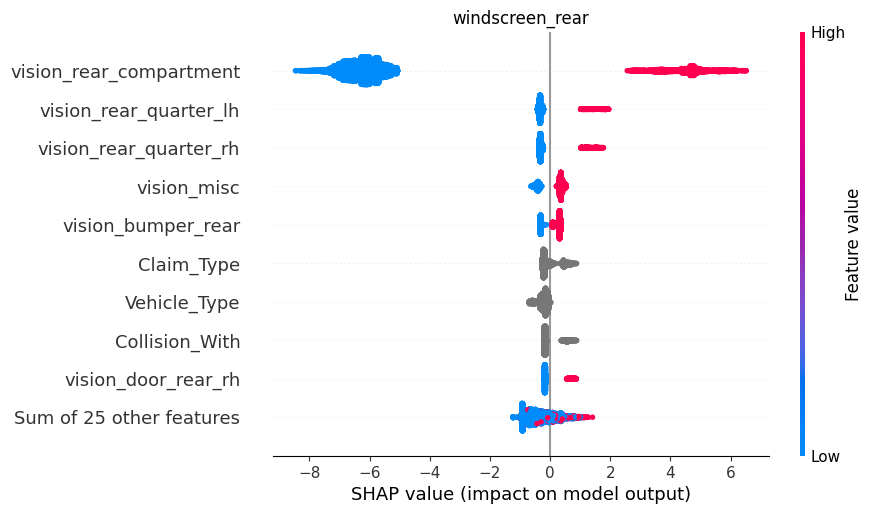

In [ ]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_test)
plt.title("windscreen_rear")
shap.plots.beeswarm(shap_values)


In [ ]:
caseStudyPred = multilabelPred.sample(n=30).head(30)
caseStudyGt = multilabelGt[multilabelGt["CaseID"].isin(caseStudyPred["CaseID"].unique().tolist())]
caseStudyPred.to_csv("case_study_pred.csv")
caseStudyGt.to_csv("case_study_gt.csv")

: 